In [145]:
# Importing Standard Libraries
import pandas as pd
import numpy as np
from csv import reader

# Sklearn Libraries
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import homogeneity_score, completeness_score, adjusted_mutual_info_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans, DBSCAN
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Importing mlxtend Libraries
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Graphing Libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [146]:
# Importing the Data Set
df =  pd.read_csv("bank.csv")
# df =  pd.read_csv("bank-full.csv")
df.head()

# Establishing copies for running through the different scrubs
df_a = df.copy()
df_b = df.copy()


# Part 2
Changing all non-numeric into category data for PCA

In [147]:
# Creating Categories for ages then making categories
df_b.loc[((df_b['age'] < 25) & (df_b['age'] >= 0)),  'ageBand'] = 1
df_b.loc[((df_b['age'] < 30) & (df_b['age'] >= 25)), 'ageBand'] = 2
df_b.loc[((df_b['age'] < 40) & (df_b['age'] >= 30)), 'ageBand'] = 3
df_b.loc[((df_b['age'] < 50) & (df_b['age'] >= 40)), 'ageBand'] = 4
df_b.loc[((df_b['age'] < 120) & (df_b['age'] >= 50)),'ageBand'] = 5
df_b['age'] = df_b['age'].astype('category')
df_b['age'] = df_b['age'].cat.codes

df_b['job'] = df_b['job'].astype('category')
df_b['job'] = df_b['job'].cat.codes
df_b['marital'] = df_b['marital'].astype('category')
df_b['marital'] = df_b['marital'].cat.codes
df_b['education'] = df_b['education'].astype('category')
df_b['education'] = df_b['education'].cat.codes
df_b['default'] = df_b['default'].astype('category')
df_b['default'] = df_b['default'].cat.codes
df_b['contact'] = df_b['contact'].astype('category')
df_b['contact'] = df_b['contact'].cat.codes
df_b['month'] = df_b['month'].astype('category')
df_b['month'] = df_b['month'].cat.codes
df_b['poutcome'] = df_b['poutcome'].astype('category')
df_b['poutcome'] = df_b['poutcome'].cat.codes
df_b['housing'] = df_b['housing'].astype('category')
df_b['housing'] = df_b['housing'].cat.codes
df_b['loan'] = df_b['loan'].astype('category')
df_b['loan'] = df_b['loan'].cat.codes
df_b['y'] = df_b['y'].astype('category')
df_b['y'] = df_b['y'].cat.codes
df_b = df_b.drop('pdays',axis=1)
df_b['balance'] = (df_b['balance'] - df_b['balance'].min()) / ( df_b['balance'].max() - df_b['balance'].min())
print("Post Conversion of Data into numeric, dropping pdays, and normalizing balance:")
df_b.head(10)

Post Conversion of Data into numeric, dropping pdays, and normalizing balance:


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y,ageBand
0,11,10,1,0,0,0.068455,0,0,0,19,10,79,1,0,3,0,3.0
1,14,7,1,1,0,0.108750,1,1,0,11,8,220,1,4,0,0,3.0
2,16,4,2,2,0,0.062590,1,0,0,16,0,185,1,1,0,0,3.0
3,11,4,1,2,0,0.064281,1,1,2,3,6,199,4,0,3,0,3.0
4,40,1,1,1,0,0.044469,1,0,2,5,8,226,1,0,3,0,5.0
5,16,4,2,2,0,0.054496,0,0,0,23,3,141,2,3,0,0,3.0
6,17,6,1,2,0,0.048590,1,0,0,14,8,341,1,2,1,0,3.0
7,20,9,1,1,0,0.046442,1,0,0,6,8,151,2,0,3,0,3.0
8,22,2,1,2,0,0.047436,1,0,2,14,8,57,2,0,3,0,4.0
9,24,7,1,0,0,0.043288,1,1,0,17,0,313,1,2,0,0,4.0


Exploratory Data Analysis

In [148]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        4521 non-null   int8   
 1   job        4521 non-null   int8   
 2   marital    4521 non-null   int8   
 3   education  4521 non-null   int8   
 4   default    4521 non-null   int8   
 5   balance    4521 non-null   float64
 6   housing    4521 non-null   int8   
 7   loan       4521 non-null   int8   
 8   contact    4521 non-null   int8   
 9   day        4521 non-null   int64  
 10  month      4521 non-null   int8   
 11  duration   4521 non-null   int64  
 12  campaign   4521 non-null   int64  
 13  previous   4521 non-null   int64  
 14  poutcome   4521 non-null   int8   
 15  y          4521 non-null   int8   
 16  ageBand    4521 non-null   float64
dtypes: float64(2), int64(4), int8(11)
memory usage: 260.6 KB


In [149]:
df_b.describe()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,previous,poutcome,y,ageBand
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,22.168104,4.411192,1.147755,1.231365,0.016810,0.063565,0.566025,0.152842,0.652289,15.915284,5.540146,263.961292,2.793630,0.542579,2.559168,0.115240,3.599425
std,10.568155,3.255716,0.599650,0.748744,0.128575,0.040397,0.495676,0.359875,0.901498,8.247667,3.002763,259.856633,3.109807,1.693562,0.992051,0.319347,0.983667
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,14.000000,1.000000,1.000000,1.000000,0.000000,0.045395,0.000000,0.000000,0.000000,9.000000,3.000000,104.000000,1.000000,0.000000,3.000000,0.000000,3.000000
50%,20.000000,4.000000,1.000000,1.000000,0.000000,0.050429,1.000000,0.000000,0.000000,16.000000,6.000000,185.000000,2.000000,0.000000,3.000000,0.000000,3.000000
75%,30.000000,7.000000,2.000000,2.000000,0.000000,0.064335,1.000000,0.000000,2.000000,21.000000,8.000000,329.000000,3.000000,0.000000,3.000000,0.000000,4.000000
max,66.000000,11.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,31.000000,11.000000,3025.000000,50.000000,25.000000,3.000000,1.000000,5.000000


The Descriptions from the data right now show that the data is displaying a lot of different scales.
Namely the following
- Age
- previous
- Duration
- Month
- Day <br>

This Leads us to believe that we need to standardize the data to bring them into scale so that our
different models are not affected disproportionately

<AxesSubplot:>

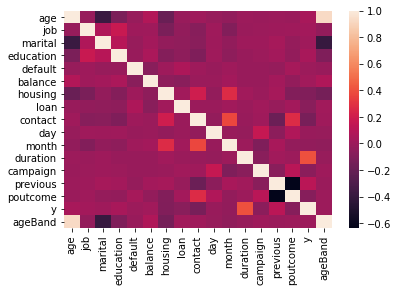

In [150]:
sns.heatmap(df_b.corr())

From the Correlation Map we can see that Y has a high correlation with marital status followed by education and housing.


Splitting the Data into X and Y

In [151]:
y = df_b["y"]
X = df_b.drop("y", axis=1)

Taking another look at the correlation of only the features

<AxesSubplot:>

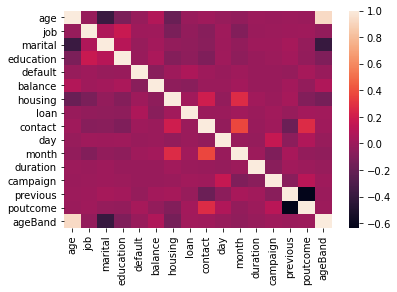

In [152]:
sns.heatmap(X.corr())

Setting the data up into training and testing splits

In [153]:
# Splitting the dataset into Train Set and Test Set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

Now I want to look at reducing the number of features and get rid of any correlation between the two

First I will want to scale the data

In [154]:
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
pca = PCA()
X_pca = pca.fit_transform(X_train_scaled)

total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X.shape[1] - n_over_95 + 1
print("Number of Features:{}".format(n_to_reach_95))
print("Total Variance Explained:{}".format(total_explained_variance[n_to_reach_95-1]))

Number of Features:14
Total Variance Explained:0.9728803255679062


In [155]:
pipe = Pipeline([('scalar', StandardScaler()),
                 ('pca', PCA(n_components=n_to_reach_95, random_state=42)),
                 ('dt', tree.DecisionTreeClassifier())])
pipe.fit(X_train,y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('pca', PCA(n_components=14, random_state=42)),
                ('dt', DecisionTreeClassifier())])

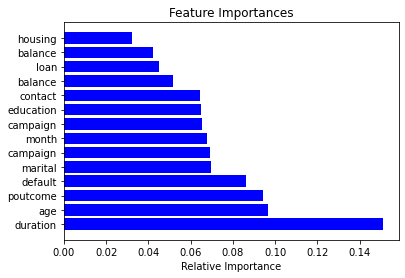

In [182]:
model = pipe.steps[1][1]
n_pcs = model.components_.shape[0]
initial_feature_names = X_train.columns
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
zipped_feats = zip(most_important_names, pipe.steps[2][1].feature_importances_)
zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)

features, importances = zip(*zipped_feats)
top_features = features[:15]
top_importances = importances[:15]

plt.title("Feature Importances")
plt.barh(range(len(top_importances)), top_importances, color='b', align='center')
plt.yticks(range(len(top_importances)), top_features)
plt.xlabel("Relative Importance")
plt.show()

The Function Below Gathers the Accuracies for the different amount of components for PCA

In [157]:
def gather_model_accuracies(class_type, name):
    """This function takes in Different Classifiers to gather accuracies"""
    accuracy = []
    for i in range(1,16):
        pipe = Pipeline([('scalar', StandardScaler()),
                         ('preprocessor', PCA(n_components=i, random_state=42)),
                         ('clf', class_type)])
        pipe.fit(X_train, y_train)
        y_prediction = pipe.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_prediction))
    accuracy = pd.DataFrame(accuracy, index=[i for i in range(1,16)], columns=[name])
    return accuracy

The Function Below Graphs the Accuracies Gathered from above

In [158]:
dtree_accuracy = gather_model_accuracies(tree.DecisionTreeClassifier(), "Decision Tree")
dtree_accuracy

,Decision Tree
1,0.790055
2,0.804420
3,0.807735
4,0.798895
5,0.795580
6,0.832044
7,0.849724
8,0.843094
9,0.846409
10,0.854144


In [159]:
gnb_accuracy = gather_model_accuracies(GaussianNB(), "Gaussian")
gnb_accuracy

,Gaussian
1,0.891713
2,0.889503
3,0.889503
4,0.890608
5,0.889503
6,0.887293
7,0.885083
8,0.889503
9,0.888398
10,0.887293


In [160]:
k_means_accuracy = gather_model_accuracies(KMeans(), "K-Means")
k_means_accuracy

,K-Means
1,0.141436
2,0.076243
3,0.140331
4,0.075138
5,0.072928
6,0.062983
7,0.129282
8,0.188950
9,0.187845
10,0.111602


Joining the Accuracies Into a Graph

In [177]:
joined_models = pd.concat([dtree_accuracy, gnb_accuracy], axis=1)
joined_models["index"] = joined_models.index

<AxesSubplot:xlabel='index', ylabel='value'>

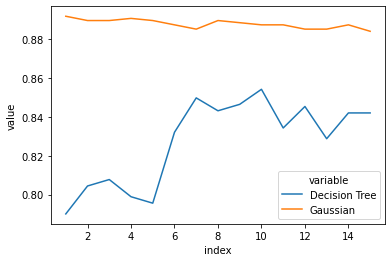

In [181]:
sns.lineplot(x = 'index', y= 'value', hue ="variable", data= pd.melt(joined_models, ['index']))